In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from collections import defaultdict

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json
import pymesh
from scipy.spatial import cKDTree
from scipy import interpolate

import torch

import trimesh.transformations as tt
import trimesh
from io import BytesIO

from joblib import Parallel, delayed

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eesfaqzi because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 1.0

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [6]:
from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.datasets.sharpf_io import save_depth_maps
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display
import sharpf.data.data_smells as smells
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes
from sharpf.utils.camera_utils.camera_pose import CameraPose
import sharpf.data.datasets.sharpf_io as io
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes

In [158]:
with ABCChunk(['/data/abc/abc_0022_obj_v00.7z', '/data/abc/abc_0022_feat_v00.7z']) as data_holder:
    item = data_holder.get('00221312_0cdd179f2b755db6d27ea303_001')

In [159]:
item.item_id

'00221312_0cdd179f2b755db6d27ea303_001'

In [160]:
config = {
  "shape_fabrication_extent": 10.0,
  "short_curve_quantile": 0.25,
  "base_n_points_per_short_curve": 8,
  "base_resolution_3d": 0.125,
  "camera_pose": {
    "type": "composite",
    "sequences": [
      {
        "type": "sphere_to_origin",
        "n_images": 18
      }
    ]
  },
  "imaging": {
    "type": "raycasting",
    "projection": "ortho",
    "resolution_image": 512,
    "resolution_3d": 0.02,
    "fov": [115, 85, 80],
    "validate_image": True
  },
  "noise": {
    "type": "z_direction",
    "scale": 0.0
  },
  "annotation": {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0
  },
  "smell_coarse_surfaces_by_num_edges": {
    "num_edges_threshold": 8
  },
  "smell_coarse_surfaces_by_angles": {
    "max_angle_threshold_degrees": 10.0
  },
  "smell_deviating_resolution": {
    "resolution_3d": 0.02,
    "resolution_deviation_tolerance": 0.01
  },
  "smell_sharpness_discontinuities": { },
  "smell_bad_face_sampling": {
    "min_points_per_face": 0.02,
    "max_points_per_face": 20.0
  },
  "smell_raycasting_background": { },
  "smell_mesh_self_intersections": { },
  "smell_depth_discontinuity": {
    "depth_discontinuity_threshold": 0.5
  }
}

In [161]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)
short_curve_quantile = config.get('short_curve_quantile', 0.05)

pose_manager = load_func_from_config(POSE_MANAGER_BY_TYPE, config['camera_pose'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])

smell_coarse_surfaces_by_num_edges = smells.SmellCoarseSurfacesByNumEdges.from_config(config['smell_coarse_surfaces_by_num_edges'])
smell_coarse_surfaces_by_angles = smells.SmellCoarseSurfacesByAngles.from_config(config['smell_coarse_surfaces_by_angles'])
smell_deviating_resolution = smells.SmellDeviatingResolution.from_config(config['smell_deviating_resolution'])
smell_sharpness_discontinuities = smells.SmellSharpnessDiscontinuities.from_config(config['smell_sharpness_discontinuities'])
smell_bad_face_sampling = smells.SmellBadFaceSampling.from_config(config['smell_bad_face_sampling'])
smell_raycasting_background = smells.SmellRaycastingBackground.from_config(config['smell_raycasting_background'])
smell_depth_discontinuity = smells.SmellDepthDiscontinuity.from_config(config['smell_depth_discontinuity'])
smell_mesh_self_intersections = smells.SmellMeshSelfIntersections.from_config(config['smell_mesh_self_intersections'])

In [162]:
def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = feature_utils.get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    scale = least_len_mm / least_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale


In [163]:
mesh, _, _ = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [164]:
mesh, mesh_scale = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                              short_curve_quantile=short_curve_quantile,
                              n_points_per_short_curve=base_n_points_per_short_curve)

mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [165]:
print(np.max(mesh.bounding_box.extents))

3.7860577612563175


In [166]:
processed_mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.faces, process=True, validate=True)
if processed_mesh.vertices.shape != mesh.vertices.shape or \
        processed_mesh.faces.shape != mesh.faces.shape or not mesh.is_watertight:
    raise DataGenerationException('Will not process mesh {}: likely the mesh is broken'.format(item.item_id))

has_smell_mismatching_surface_annotation = any([
    np.array(np.unique(mesh.faces[surface['face_indices']]) != np.sort(surface['vert_indices'])).all()
    for surface in features['surfaces']
])
has_smell_mesh_self_intersections = smell_mesh_self_intersections.run(mesh)


In [167]:
sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in features['curves'] if c['sharp']]
)
sharp_vert = mesh.vertices[sharp_vert_indexes]


display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=HIGH_RES / 2,
    sharp_vert=sharp_vert, sharpvert_psize=MED_RES,
    samples=None, samples_psize=HIGH_RES,
)

Output()

In [196]:
patches = []

# generate camera poses
pose_manager.prepare(mesh)

In [197]:
pose_manager_iter = iter(pose_manager)

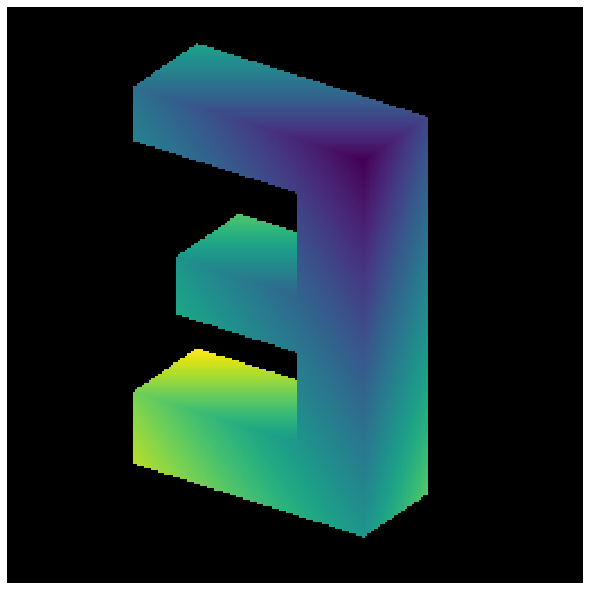

In [202]:
camera_pose = next(pose_manager_iter)
# extract neighbourhood
try:
    image, points, normals, mesh_face_indexes = \
        imaging.get_image_from_pose(mesh, camera_pose, return_hit_face_indexes=True)
except DataGenerationException as e:
    eprint_t(str(e))
    
display_depth_sharpness(
    depth_images=[image.T[128:-128, 128:-128]]
)

In [215]:
# camera_to_world = np.linalg.inv(camera_pose.world_to_camera_4x4)

# # camera_to_world = pose.camera_to_world_4x4

# camera_center = np.array([
#     camera_pose.frame_origin,
#     camera_pose.frame_origin,
#     camera_pose.frame_origin,
# ])

# camera_frame = np.array([
#     camera_pose.frame_axes
# ]) * 25

# display_sharpness(
#     mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
#     samples=camera_center, samples_psize=5.0,
#     directions=camera_frame
# )

NameError: name 'camera_center' is not defined

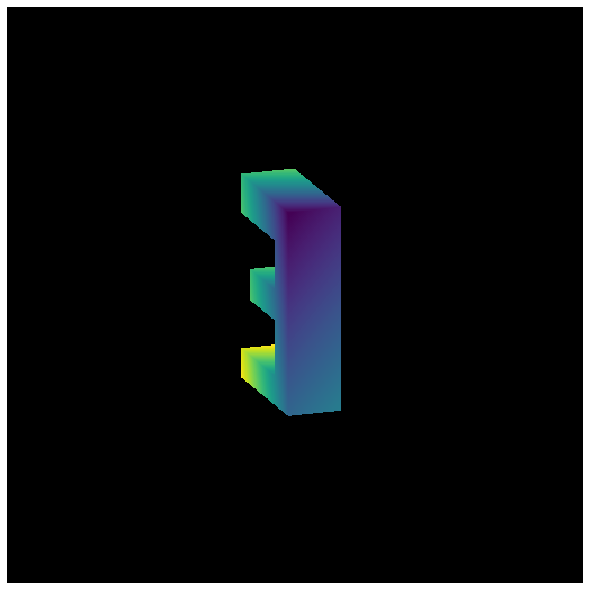

In [203]:
has_smell_coarse_surfaces_by_num_edges = smell_coarse_surfaces_by_num_edges.run(mesh, mesh_face_indexes, features)
has_smell_coarse_surfaces_by_angles = smell_coarse_surfaces_by_angles.run(mesh, mesh_face_indexes, features)
has_smell_deviating_resolution = smell_deviating_resolution.run(points)
has_smell_bad_face_sampling = smell_bad_face_sampling.run(nbhood, points)
has_smell_raycasting_background = smell_raycasting_background.run(image)
has_smell_depth_discontinuity = smell_depth_discontinuity.run(image)

In [204]:
nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, mesh_face_indexes)

# create annotations: condition the features onto the nbhood
nbhood_features = feature_utils.compute_features_nbhood(
    mesh, features, mesh_face_indexes, mesh_vertex_indexes=mesh_vertex_indexes,
    deduce_verts_from_faces=False)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = feature_utils.remove_boundary_features(nbhood, nbhood_features, how='edges')

In [205]:
nbhood_sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in nbhood_features['curves'] if c['sharp']]
)
nbhood_sharp_vert = nbhood.vertices[nbhood_sharp_vert_indexes]


display_sharpness(
    nbhood, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    sharp_vert=nbhood_sharp_vert, sharpvert_psize=0.2,
    samples=camera_pose.camera_to_world(imaging.image_to_points(image)), samples_psize=0.1,
    directions=None
)

Output()

In [219]:
noisy_points = noiser.make_noise(
    camera_pose.world_to_camera(points),
    normals,
    z_direction=np.array([0., 0., -1.]))

In [220]:
annotator.validate_annotation = False

In [221]:
# compute the TSharpDF
try:
    distances, directions, has_sharp = annotator.annotate(
        nbhood, nbhood_features, camera_pose.camera_to_world(noisy_points))
except DataGenerationException as e:
    eprint_t(str(e))

In [222]:
display_sharpness(
    nbhood, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=camera_pose.camera_to_world(noisy_points), samples_psize=HIGH_RES,
    samples_distances=distances,
)

Output()

In [223]:
ray_indexes = np.where(image.ravel() != 0)[0]
noisy_image = imaging.points_to_image(noisy_points, ray_indexes)
normals_image = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])
distances_image = imaging.points_to_image(distances.reshape(-1, 1), ray_indexes, assign_channels=[0])
directions_image = imaging.points_to_image(directions, ray_indexes, assign_channels=[0, 1, 2])

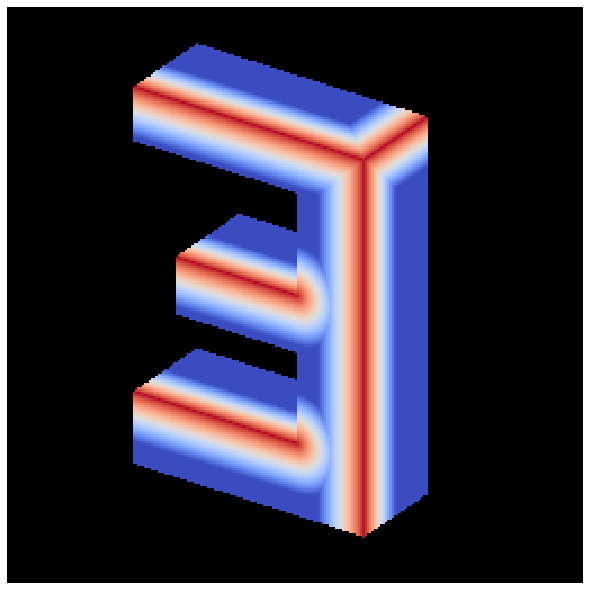

In [225]:
display_depth_sharpness(
#     depth_images=[camera_to_display(noisy_image)],
    sharpness_images=[distances_image.T[128:-128, 128:-128]],
    axes_size=(8, 8), 
    ncols=1
)

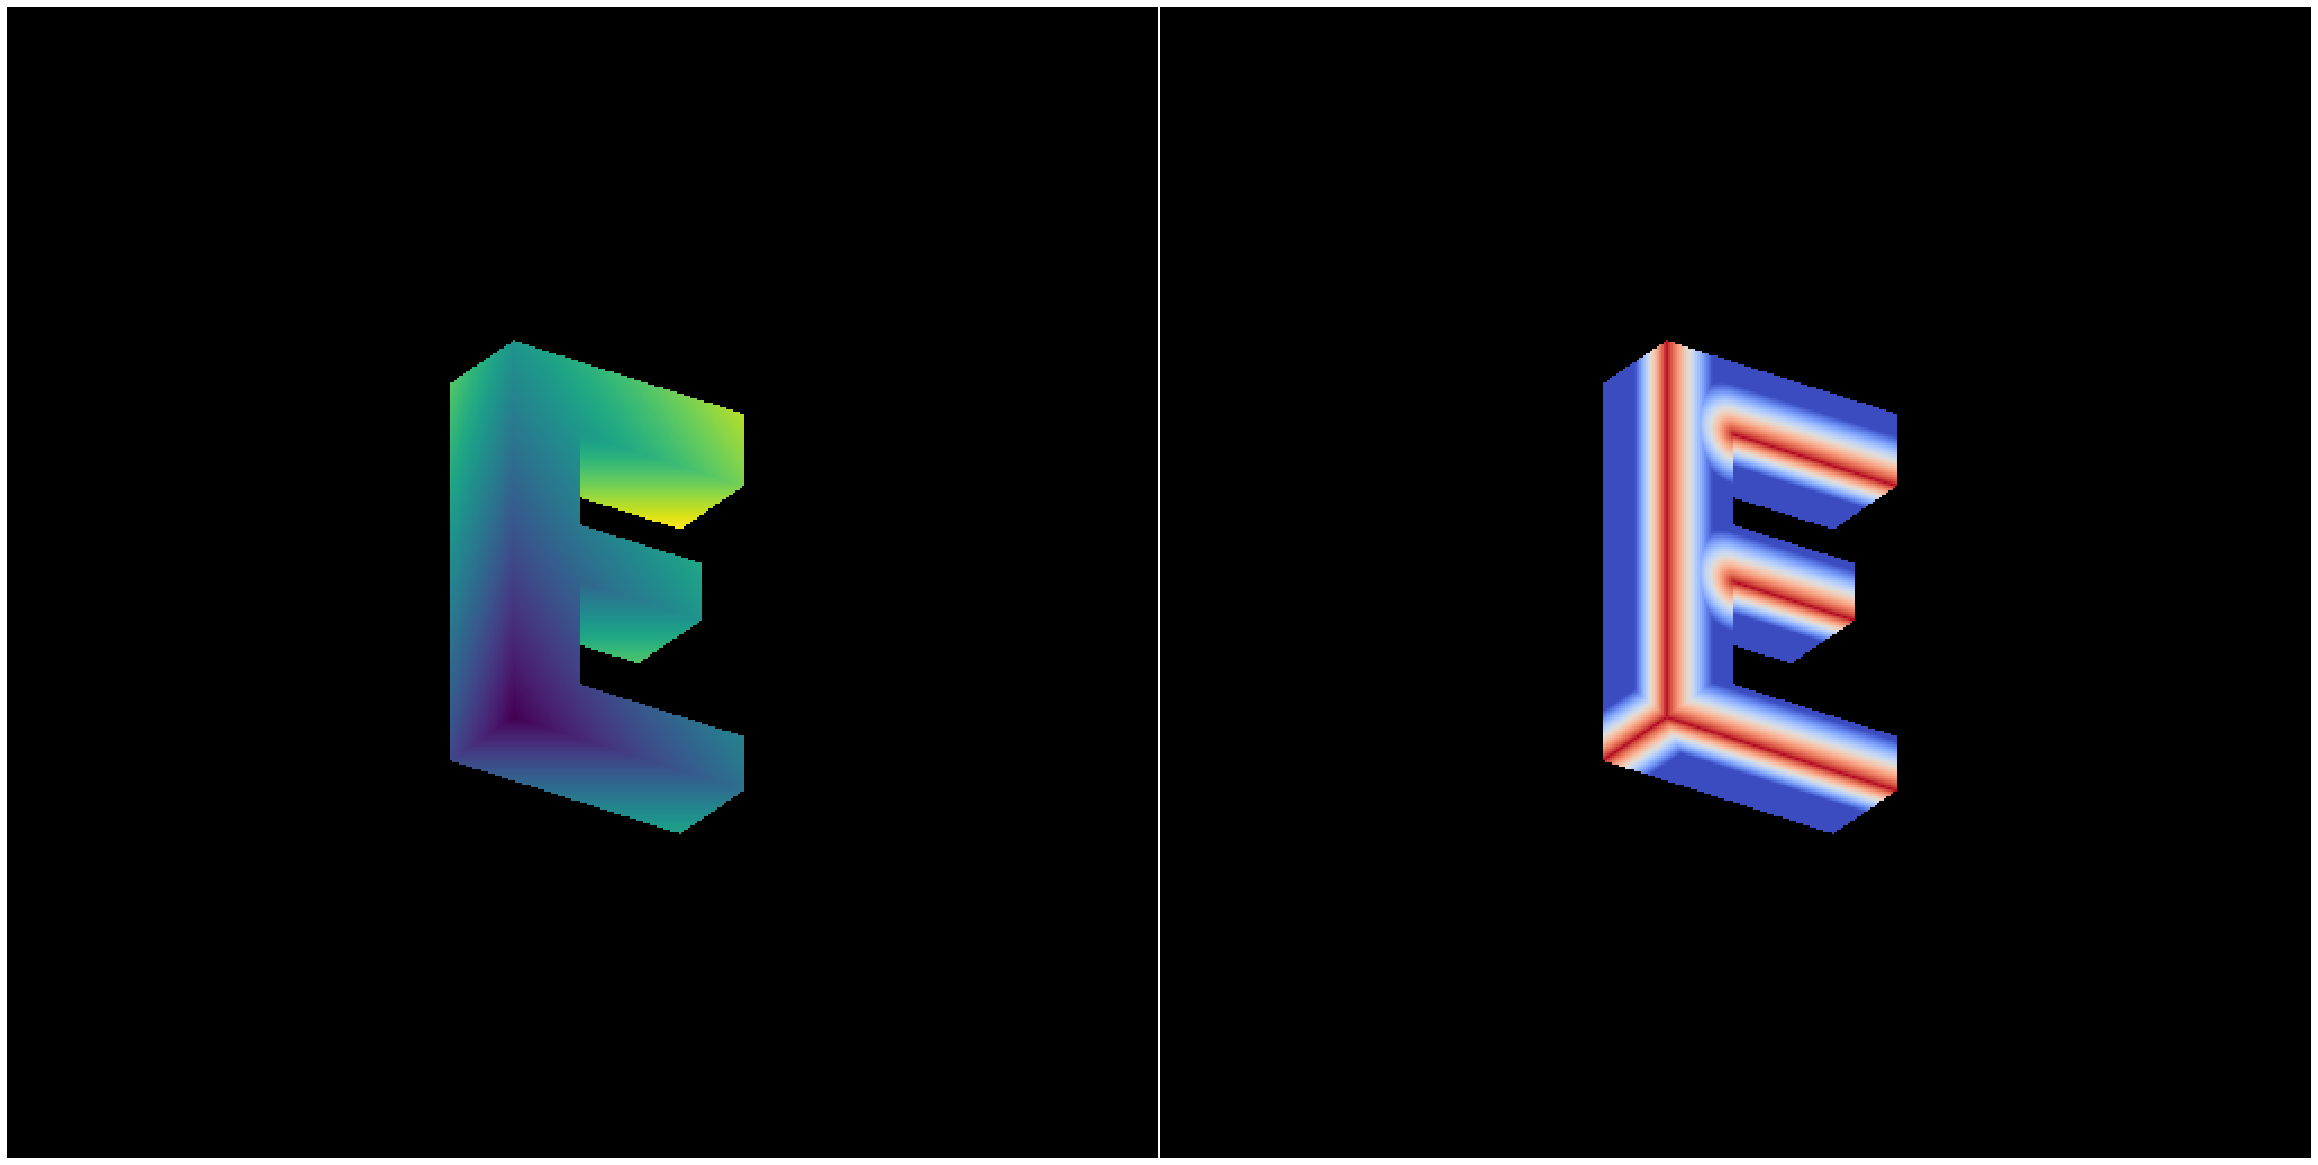

In [224]:
display_depth_sharpness(
    depth_images=[camera_to_display(noisy_image)],
    sharpness_images=[camera_to_display(distances_image)],
    axes_size=(16, 16), 
)

In [ ]:
# compute statistics
num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
num_surfaces = len(nbhood_features['surfaces'])

In [ ]:
try:
    has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(noisy_points, distances)
except Exception as e:
    eprint_t(str(e))
    

In [ ]:
patch_info = {
    'ray_indexes': ray_indexes,
    'image': noisy_image,
    'normals': normals_image,
    'distances': distances_image,
    'directions': directions_image,
    'item_id': item.item_id,
    'orig_vert_indices': mesh_vertex_indexes,
    'orig_face_indexes': mesh_face_indexes,
    'has_sharp': has_sharp,
    'num_sharp_curves': num_sharp_curves,
    'num_surfaces': num_surfaces,
    'camera_pose': camera_pose.camera_to_world_4x4,
    'mesh_scale': mesh_scale,
    'has_smell_coarse_surfaces_by_num_faces': has_smell_coarse_surfaces_by_num_edges,
    'has_smell_coarse_surfaces_by_angles': has_smell_coarse_surfaces_by_angles,
    'has_smell_deviating_resolution': has_smell_deviating_resolution,
    'has_smell_sharpness_discontinuities': has_smell_sharpness_discontinuities,
    'has_smell_bad_face_sampling': has_smell_bad_face_sampling,
    'has_smell_mismatching_surface_annotation': has_smell_mismatching_surface_annotation,
    'has_smell_raycasting_background': has_smell_raycasting_background,
    'has_smell_depth_discontinuity': has_smell_depth_discontinuity,
    'has_smell_mesh_self_intersections': has_smell_mesh_self_intersections,
}

In [ ]:
patches.append(patch_info)

In [ ]:
whole_model_points = []
whole_model_distances = []

for patch in patches:
    image = patch['image']
    points_in_camera_frame = imaging.image_to_points(image)
    camera_to_world_4x4 = patch['camera_pose']
    camera_pose = CameraPose(camera_to_world_4x4)
    points_in_world_frame = camera_pose.camera_to_world(points_in_camera_frame)
    whole_model_points.append(points_in_world_frame)
    
    distances = patch['distances']
    whole_model_distances.append(distances.ravel()[np.where(distances.ravel() != 0.)[0]])
    

whole_model_points = np.concatenate(whole_model_points)
whole_model_distances = np.concatenate(whole_model_distances)

In [ ]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances,
)



In [ ]:
import igl

In [ ]:
nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, patches[0]['orig_face_indexes'])


In [ ]:
distance_sq, face_indexes, _ = igl.point_mesh_squared_distance(
    whole_model_points,
    nbhood.vertices,
    nbhood.faces)
indexes = np.where(np.sqrt(distance_sq) < HIGH_RES / 100)[0]
points, normals = whole_model_points[indexes], nbhood.face_normals[face_indexes[indexes]]




In [ ]:
from sharpf.utils.abc_utils.abc.feature_utils import compute_features_nbhood, remove_boundary_features, get_curves_extents

def compute_patches(
        patch,
        whole_model_points,
        mesh,
        features,
        noiser,
        annotator,
        smell_coarse_surfaces_by_num_edges,
        smell_coarse_surfaces_by_angles,
        smell_deviating_resolution,
        smell_bad_face_sampling,
        smell_sharpness_discontinuities):


    # extract neighbourhood
    nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, patch['orig_face_indexes'])

    has_smell_coarse_surfaces_by_num_edges = smell_coarse_surfaces_by_num_edges.run(mesh, mesh_face_indexes, features)
    has_smell_coarse_surfaces_by_angles = smell_coarse_surfaces_by_angles.run(mesh, mesh_face_indexes, features)

    # create annotations: condition the features onto the nbhood
    nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes,
                                              mesh_vertex_indexes=mesh_vertex_indexes)

    # remove vertices lying on the boundary (sharp edges found in 1 face only)
    nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

    # sample the neighbourhood to form a point patch
#     try:
#         points, normals = sampler.sample(nbhood, centroid=nbhood_extractor.centroid)
#     except DataGenerationException as e:
#         eprint_t(str(e))
#         return None

    distance_sq, face_indexes, _ = igl.point_mesh_squared_distance(
        whole_model_points,
        nbhood.vertices,
        nbhood.faces)
    indexes = np.where(np.sqrt(distance_sq) < HIGH_RES / 100)[0]
    points, normals = whole_model_points[indexes], nbhood.face_normals[face_indexes[indexes]]

    has_smell_deviating_resolution = smell_deviating_resolution.run(points)
    has_smell_bad_face_sampling = smell_bad_face_sampling.run(nbhood, points)

    # create a noisy sample
    noisy_points = noiser.make_noise(points, normals, z_direction=np.array([0., 0., -1.]))
    
    try:
        distances, directions, has_sharp = annotator.annotate(nbhood, nbhood_features, noisy_points)
    except DataGenerationException as e:
        eprint_t(str(e))
        return None 

    has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(noisy_points, distances)

    num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
    num_surfaces = len(nbhood_features['surfaces'])
    patch = {
        'points': np.array(noisy_points).astype(np.float64),
        'normals': np.array(normals).astype(np.float64),
        'distances': np.array(distances).astype(np.float64),
        'directions': np.array(directions).astype(np.float64),
        'orig_vert_indices': np.array(mesh_vertex_indexes).astype(np.int32),
        'orig_face_indexes': np.array(mesh_face_indexes).astype(np.int32),
        'has_sharp': has_sharp,
        'num_sharp_curves': num_sharp_curves,
        'num_surfaces': num_surfaces,
        'has_smell_coarse_surfaces_by_num_faces': has_smell_coarse_surfaces_by_num_edges,
        'has_smell_coarse_surfaces_by_angles': has_smell_coarse_surfaces_by_angles,
        'has_smell_deviating_resolution': has_smell_deviating_resolution,
        'has_smell_sharpness_discontinuities': has_smell_sharpness_discontinuities,
        'has_smell_bad_face_sampling': has_smell_bad_face_sampling,
#         'has_smell_mismatching_surface_annotation': has_smell_mismatching_surface_annotation,
        'nbhood': nbhood,
        'indexes': indexes
    }
    return patch

In [ ]:
patch = patches[0]
consolidated_patch = compute_patches(
    patch,
    whole_model_points,
    mesh,
    features,
    noiser,
    annotator,
    smell_coarse_surfaces_by_num_edges,
    smell_coarse_surfaces_by_angles,
    smell_deviating_resolution,
    smell_bad_face_sampling,
    smell_sharpness_discontinuities)

In [ ]:
parallel = Parallel(n_jobs=16, backend='multiprocessing', verbose=100)
delayed_iterable = (delayed(compute_patches)(
    patch,
    whole_model_points,
    mesh,
    features,
    noiser,
    annotator,
    smell_coarse_surfaces_by_num_edges,
    smell_coarse_surfaces_by_angles,
    smell_deviating_resolution,
    smell_bad_face_sampling,
    smell_sharpness_discontinuities)
for patch in patches)
consolidated_patches = parallel(delayed_iterable)

In [ ]:
whole_model_distances = np.ones(len(whole_model_points)) * np.inf
whole_model_directions = np.ones( (len(whole_model_points), 3) ) * np.inf

for patch in tqdm(consolidated_patches):
    distances = patch['distances']
    directions = patch['directions']
    indexes = patch['indexes']

    assign_mask = whole_model_distances[indexes] > distances
    whole_model_distances[indexes[assign_mask]] = distances[assign_mask]
    whole_model_directions[indexes[assign_mask]] = directions[assign_mask]
    

In [ ]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances,
)




In [ ]:
whole_model_points

In [ ]:

whole_patches = []
for non_annotated, annotated in zip(patches, consolidated_patches):
    whole_patch = deepcopy(non_annotated)
    whole_patch['distances'] = imaging.points_to_image(
        whole_model_distances[annotated['indexes']],
        non_annotated['ray_indexes'],
        assign_channels=[0])
    whole_patch['directions'] = imaging.points_to_image(
        whole_model_directions[annotated['indexes'], :],
        non_annotated['ray_indexes'],
        assign_channels=[0, 1, 2])
    whole_patch['has_smell_mismatching_surface_annotation'] = has_smell_mismatching_surface_annotation
    whole_patch['has_smell_sharpness_discontinuities'] = annotated['has_smell_sharpness_discontinuities']
    whole_patch['has_sharp'] = annotated['has_sharp']
    whole_patch['item_id'] = data['item_id']
    whole_patch.pop('nbhood')
    whole_patch.pop('nbhood_features')
    whole_patch.pop('ray_indexes')
    whole_patch['indexes_in_whole'] = annotated['indexes']
    whole_patches.append(whole_patch)

In [ ]:
dataset = Hdf5File('/logs/whole_images/abc_0022_00221312_0cdd179f2b755db6d27ea303_001.hdf5',
                   io=io.IO_SPECS['images'],
                   preload=PreloadTypes.LAZY,
                   labels='*')

In [ ]:
images = [patch['image'] for patch in dataset]
distances = [patch['distances'] for patch in dataset]

In [ ]:
# display_depth_sharpness(
#     depth_images=images,
#     sharpness_images=distances,
#     axes_size=(16, 16),
#     ncols=2
# )

In [ ]:
def cut_into_overlapping_patches(
    noisy_image,
    normals,
    distances,
    directions,
    canvas_size,
    patch_size,
    overlap_amount,
):

    patch_images = []
    patch_normals = []
    patch_distances = []
    patch_directions = []
    patch_indexes = []

    row_indexes = np.arange(0, canvas_size - patch_size, overlap_amount)
    col_indexes = np.arange(0, canvas_size - patch_size, overlap_amount)
    
    for row in row_indexes:
        for col in col_indexes:
            patch_images.append(noisy_image[row:row + patch_size, col:col + patch_size])
            patch_normals.append(normals[row:row + patch_size, col:col + patch_size])
            patch_distances.append(distances[row:row + patch_size, col:col + patch_size])
            patch_directions.append(directions[row:row + patch_size, col:col + patch_size])
            patch_indexes.append([row, col])
    
    patch_images = np.array(patch_images)
    patch_normals = np.array(patch_normals)
    patch_distances = np.array(patch_distances)
    patch_directions = np.array(patch_directions)
    patch_indexes = np.array(patch_indexes)

    nonempty_indexes = np.where(~np.all(patch_images == 0., axis=(1,2)))[0]

    return (patch_images[nonempty_indexes],
            patch_normals[nonempty_indexes],
            patch_distances[nonempty_indexes],
            patch_directions[nonempty_indexes],
            patch_indexes[nonempty_indexes])

In [ ]:
idx = -2
patch = dataset[idx]

noisy_image = patch['image']
normals = patch['normals']
distances = patch['distances']
directions = patch['directions']
camera_to_world_4x4 = patch['camera_pose']

In [ ]:
patch_images, patch_normals, patch_distances, patch_directions, patch_indexes = cut_into_overlapping_patches(
    noisy_image,
    normals,
    distances,
    directions,
    canvas_size=512,
    patch_size=32,
    overlap_amount=8)

In [ ]:
has_smell_raycasting_background_patch_images = np.array([
    smell_raycasting_background.run(image) for image in patch_images])

has_smell_depth_discontinuity_patch_images = np.array([
    smell_depth_discontinuity.run(image) for image in patch_images])

In [ ]:
i = np.where(~(has_smell_raycasting_background_patch_images | has_smell_depth_discontinuity_patch_images))[0]

In [ ]:
display_depth_sharpness(
    depth_images=patch_images[i[-20:]],
    sharpness_images=patch_distances[i[-20:]],
    axes_size=(16, 16),
    ncols=10
)

In [ ]:
def image_from_patch(resolution_image, patch_image, patch_indexes):
    image = np.zeros((resolution_image, resolution_image))
    row, col = patch_indexes
    patch_rows, patch_cols = patch_image.shape
    image[row:row + patch_rows, col:col + patch_cols] = patch_image
    return image

In [ ]:
whole_model_points = []
whole_model_distances = []

small_patches = []

for patch in tqdm(dataset):
    noisy_image = patch['image']
    normals = patch['normals']
    distances = patch['distances']
    directions = patch['directions']
    camera_to_world_4x4 = patch['camera_pose']
    camera_pose = CameraPose(camera_to_world_4x4)
    
    patch_images, patch_normals, patch_distances, patch_directions, patch_indexes = cut_into_overlapping_patches(
        noisy_image,
        normals,
        distances,
        directions,
        canvas_size=512,
        patch_size=32,
        overlap_amount=8)
    
    has_smell_raycasting_background_patch_images = np.array([
        smell_raycasting_background.run(image) for image in patch_images])

    has_smell_depth_discontinuity_patch_images = np.array([
        smell_depth_discontinuity.run(image) for image in patch_images])
    
    idx = np.where(~(has_smell_raycasting_background_patch_images | 
                     has_smell_depth_discontinuity_patch_images))[0]
    
    for i in idx:
        image = image_from_patch(imaging.resolution_image, patch_images[i], patch_indexes[i])
        points_in_camera_frame = imaging.image_to_points(image)
        points_in_world_frame = camera_pose.camera_to_world(points_in_camera_frame)
        whole_model_points.append(points_in_world_frame)
        whole_model_distances.append(patch_distances[i].ravel())
        
        small_patch = deepcopy(patch)
        small_patch['image'] = patch_images[i]
        small_patch['normals'] = patch_normals[i]
        small_patch['distances'] = patch_distances[i]
        small_patch['directions'] = patch_directions[i]
        small_patch['indexes_in_whole'] = patch_indexes[i]
        small_patches.append(small_patch)



In [ ]:
whole_model_points, idx = np.unique(
    np.concatenate(whole_model_points),
    axis=0, return_index=True)
whole_model_distances = np.concatenate(whole_model_distances)[idx]

In [ ]:
whole_model_points.shape

In [ ]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances,
)

In [ ]:
import h5py
from functools import partial
import sharpf.utils.abc_utils.hdf5.io_struct as io

WholeDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'normals': io.Float64('normals'),
        'distances': io.Float64('distances'),
        'directions': io.Float64('directions'),
        'indexes_in_whole': io.Float64('indexes_in_whole'),
        'item_id': io.AsciiString('item_id'),
        'orig_vert_indices': io.VarInt32('orig_vert_indices'),
        'orig_face_indexes': io.VarInt32('orig_face_indexes'),
        'has_sharp': io.Bool('has_sharp'),
        'num_sharp_curves': io.Int8('num_sharp_curves'),
        'num_surfaces': io.Int8('num_surfaces'),
        'camera_pose': io.Float64('camera_pose'),
        'mesh_scale': io.Float64('mesh_scale'),
        'has_smell_coarse_surfaces_by_num_faces': io.Bool('has_smell_coarse_surfaces_by_num_faces'),
        'has_smell_coarse_surfaces_by_angles': io.Bool('has_smell_coarse_surfaces_by_angles'),
        'has_smell_deviating_resolution': io.Bool('has_smell_deviating_resolution'),
        'has_smell_sharpness_discontinuities': io.Bool('has_smell_sharpness_discontinuities'),
        'has_smell_bad_face_sampling': io.Bool('has_smell_bad_face_sampling'),
        'has_smell_mismatching_surface_annotation': io.Bool('has_smell_mismatching_surface_annotation'),
        'has_smell_raycasting_background': io.Bool('has_smell_raycasting_background'),
        'has_smell_depth_discontinuity': io.Bool('has_smell_depth_discontinuity'),
        'has_smell_mesh_self_intersections': io.Bool('has_smell_mesh_self_intersections'),
    },
    len_label='has_sharp',
    compression='lzf')


def save_whole_images(patches, filename):
    # turn a list of dicts into a dict of torch tensors:
    # default_collate([{'a': 'str1', 'x': np.random.normal()}, {'a': 'str2', 'x': np.random.normal()}])
    # Out[26]: {'a': ['str1', 'str2'], 'x': tensor([0.4252, 0.1414], dtype=torch.float64)}
    collate_fn = partial(io.collate_mapping_with_io, io=WholeDepthMapIO)
    patches = collate_fn(patches)

    with h5py.File(filename, 'w') as f:
        for key in ['image', 'normals', 'distances', 'directions', 'indexes_in_whole']:
            WholeDepthMapIO.write(f, key, patches[key].numpy())
        WholeDepthMapIO.write(f, 'item_id', patches['item_id'])
        WholeDepthMapIO.write(f, 'orig_vert_indices', patches['orig_vert_indices'])
        WholeDepthMapIO.write(f, 'orig_face_indexes', patches['orig_face_indexes'])
        WholeDepthMapIO.write(f, 'has_sharp', patches['has_sharp'].numpy().astype(np.bool))
        WholeDepthMapIO.write(f, 'num_sharp_curves', patches['num_sharp_curves'].numpy())
        WholeDepthMapIO.write(f, 'num_surfaces', patches['num_surfaces'].numpy())
        WholeDepthMapIO.write(f, 'camera_pose', patches['camera_pose'].numpy())
        WholeDepthMapIO.write(f, 'mesh_scale', patches['mesh_scale'].numpy())
        has_smell_keys = [key for key in WholeDepthMapIO.datasets.keys()
                          if key.startswith('has_smell')]
        for key in has_smell_keys:
            WholeDepthMapIO.write(f, key, patches[key].numpy().astype(np.bool))


In [ ]:
save_whole_images(small_patches, '/logs/whole_images/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32.hdf5')

In [ ]:
gt_dataset = Hdf5File(
    '/logs/whole_images/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [ ]:
PredictionsIO = io.HDF5IO({
    'distances': io.Float64('distances'),
},
len_label='distances',
compression='lzf')

pred_dataset = Hdf5File(
    '/logs/whole_images/predictions/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32/predictions/test_predictions_0.hdf5',
    io=PredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [ ]:
pred_distances = [p['distances'] for p in pred_dataset]

In [ ]:
gt_images = [p['image'] for p in gt_dataset]

In [ ]:


display_depth_sharpness(
    depth_images=gt_images[30:40],
    sharpness_images=pred_distances[30:40],
    axes_size=(8, 8),
    ncols=10
)

In [ ]:
whole_model_points = []
whole_model_pred_distances = []

small_patches = []

for patch, pred_patch in tqdm(zip(gt_dataset, pred_dataset)):
    noisy_image = patch['image']
    normals = patch['normals']
    distances = pred_patch['distances']
    directions = patch['directions']
    camera_to_world_4x4 = patch['camera_pose']
    camera_pose = CameraPose(camera_to_world_4x4)
    indexes = patch['indexes_in_whole'].astype(int)

    image = image_from_patch(imaging.resolution_image, noisy_image, indexes)
    points_in_camera_frame = imaging.image_to_points(image)
    points_in_world_frame = camera_pose.camera_to_world(points_in_camera_frame)
    whole_model_points.append(points_in_world_frame)
    whole_model_pred_distances.append(distances.ravel())


whole_model_points, idx = np.unique(
    np.concatenate(whole_model_points),
    axis=0, return_index=True)
whole_model_pred_distances = np.concatenate(whole_model_pred_distances)[idx]

In [ ]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_pred_distances,
)

In [ ]:
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import glob
import re


def convert_npylist_to_hdf5(input_dir, output_filename):
    PointPatchPredictionsIO = io_struct.HDF5IO(
        {'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')

    def save_predictions(patches, filename):
        collate_fn = partial(io_struct.collate_mapping_with_io, io=PointPatchPredictionsIO)
        patches = collate_fn(patches)
        with h5py.File(filename, 'w') as f:
            PointPatchPredictionsIO.write(f, 'distances', patches['distances'])

    def get_num(basename):
        match = re.match('^test_(\d+)\.npy$', basename)
        return int(match.groups()[0])

    datafiles = glob.glob(os.path.join(input_dir, '*.npy'))
    datafiles.sort(key=lambda name: get_num(os.path.basename(name)))
    patches = [{'distances': np.load(f)} for f in datafiles]
    save_predictions(patches, output_filename)


In [ ]:
!ls /data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_arbitrary

In [ ]:
convert_npylist_to_hdf5(
    '/data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_arbitrary/predictions',
    '/data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_arbitrary/test_predictions_0.hdf5'
)

In [ ]:
PredictionsIO = io.HDF5IO({
    'distances': io.Float64('distances'),
},
len_label='distances',
compression='lzf')

pred_dataset = Hdf5File(
    '/data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_arbitrary/test_predictions_0.hdf5',
    io=PredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_distances = [p['distances'][128:-128, 128:-128] for p in pred_dataset]
# pred_distances = [p['distances'] for p in pred_dataset]


In [67]:
gt_dataset = Hdf5File(
    '/data/abc/sharp_features_whole_models/whole_images/high_res/50/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007.hdf5',
    io=io.WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

# gt_images = [camera_to_display(p['image'])[256+64:-256-64, 256+64:-256-64] for p in gt_dataset]
# gt_distances = [camera_to_display(p['distances'])[256+64:-256-64, 256+64:-256-64] for p in gt_dataset]
gt_images = [camera_to_display(p['image']) for p in gt_dataset]
gt_distances = [camera_to_display(p['distances']) for p in gt_dataset]
gt_cameras = [p['camera_pose'] for p in gt_dataset]

# gt_images = [p['image'][128:-128, 128:-128] for p in gt_dataset]
# gt_distances = [p['distances'][128:-128, 128:-128] for p in gt_dataset]


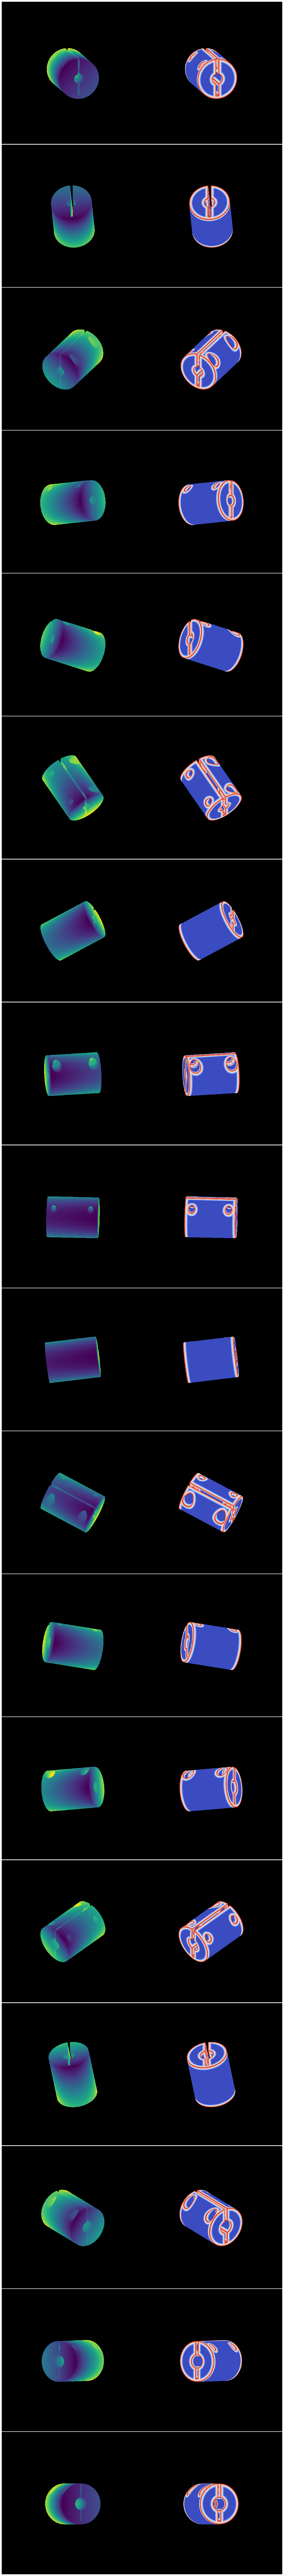

In [68]:
display_depth_sharpness(
    depth_images=gt_images,
    sharpness_images=gt_distances,
    axes_size=(8, 8),
    ncols=1
)

In [ ]:
pred_distances_masked = []
for image, distances in zip(gt_images, pred_distances):
    distances_masked = np.zeros_like(distances)
    distances_masked[image == 0.] = 0.
    distances_masked[image != 0.] = distances[image != 0.]
    pred_distances_masked.append(distances_masked)

In [ ]:
display_depth_sharpness(
    depth_images=gt_images[:1],
    sharpness_images=pred_distances_masked[:1],
    axes_size=(8, 8),
    ncols=1
)

In [ ]:
n_points_per_image = np.array([len(np.nonzero(image.ravel())[0]) for image in gt_images])


In [ ]:
n_points_per_image.sum()

In [ ]:
whole_model_points = []
whole_model_distances_pred = []

for camera_to_world_4x4, image, predictions in zip(gt_cameras, gt_images, pred_distances):
    points_in_camera_frame = imaging.image_to_points(image)
    camera_pose = CameraPose(camera_to_world_4x4)
    points_in_world_frame = camera_pose.camera_to_world(points_in_camera_frame)
    whole_model_points.append(points_in_world_frame)
    whole_model_distances_pred.append(predictions[image != 0].ravel())


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)


def local_linear_fit(X, y):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('feat', PolynomialFeatures(2)),
        ('reg', HuberRegressor(epsilon=4., alpha=1., max_iter=1000))])
    try:
        y_pred = pipe.fit(X, y).predict(X)
    except ValueError:
        y_pred = None
    return y_pred

In [ ]:
def data_maker(points, nn_indexes):
    for other_point_index, indexes in enumerate(nn_indexes):
        close_to_other = indexes[indexes != len(points)]
        if len(close_to_other) > 8:
            y = np.concatenate((
                distances[close_to_other],
                other_view_distances[other_point_index:other_point_index + 1]))

            X = np.concatenate((
                points[close_to_other],
                other_view_points[other_point_index:other_point_index + 1]))

            yield X, y, other_point_index

In [ ]:
n_omp_threads = int(os.environ.get('OMP_NUM_THREADS', 1))
n_neighbours = 16

prediction_variants = defaultdict(list)

for points, distances in zip(whole_model_points, whole_model_distances_pred):
    # propagate THIS view to all OTHER views
    tree = cKDTree(points, leafsize=100)    

    prev_index = 0
    for other_view_points, other_view_distances in zip(whole_model_points, whole_model_distances_pred):
        print(prev_index)
        for other_index, other_distance in zip(range(len(other_view_points)), other_view_distances):
            prediction_variants[prev_index + other_index].append(other_distance)
        
        if not (points is other_view_points):

            nn_distances, nn_indexes = tree.query(
                other_view_points,
                k=n_neighbours,
                distance_upper_bound=HIGH_RES * 4.,
                n_jobs=n_omp_threads)
            
            parallel = Parallel(n_jobs=32, batch_size=64, backend='loky', verbose=1)
            delayed_iterable = (delayed(local_linear_fit)(X, y)
                                for X, y, _ in data_maker(points, nn_indexes))
            this_view_predictions = parallel(delayed_iterable)
            
            for y_pred, (X, y, other_point_index) in zip(this_view_predictions, data_maker(points, nn_indexes)):
                if None is not y_pred:
                    prediction_variants[prev_index + other_point_index].append(y_pred[-1])

        prev_index += len(other_view_points)


In [ ]:
np.concatenate(whole_model_points).shape

In [ ]:
whole_model_distances = np.ones(len(whole_model_points)) * np.inf

for patch in tqdm(consolidated_patches):
    distances = patch['distances']
    directions = patch['directions']
    indexes = patch['indexes']

    assign_mask = whole_model_distances[indexes] > distances
    whole_model_distances[indexes[assign_mask]] = distances[assign_mask]
    whole_model_directions[indexes[assign_mask]] = directions[assign_mask]
    

In [ ]:
gt_distances

In [ ]:
whole_model_distances_pred_min = np.zeros(len(np.concatenate(whole_model_points)))
for idx, values in prediction_variants.items():
    whole_model_distances_pred_min[idx] = np.min(values)

In [ ]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=np.concatenate(whole_model_points),
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances_pred_min,
)

In [ ]:
pixel_space_tree = cKDTree(imaging.rays_origins[:, :2], leafsize=100)

In [ ]:
prediction_variants = defaultdict(list)

for i in tqdm(range(18)):

# i = 0
    points_i, distances_i = whole_model_points[i], whole_model_distances_pred[i]
    pose_i = CameraPose(gt_cameras[i])
    image_i = gt_images[i].ravel()
    pred_distances_i = pred_distances_masked[i].ravel()


    whole_model_points_interp = []
    whole_model_distances_interp = []
    whole_model_can_interp = []

    for j in tqdm(range(18)):
        if i == j:
            whole_model_points_interp.append(points_i)
            whole_model_distances_interp.append(distances_i)
            whole_model_can_interp.append(np.ones(len(points_i)).astype(bool))
            continue

        points_j, distances_j = whole_model_points[j], whole_model_distances_pred[j]    
        pose_j = CameraPose(gt_cameras[j])
        image_j = gt_images[j].ravel()
        pred_distances_j = pred_distances_masked[j].ravel()
        reprojected = pose_i.world_to_camera(points_j)

        nn_distances, nn_indexes = pixel_space_tree.query(
            reprojected[:, :2],
            k=4,
            n_jobs=n_omp_threads)


        can_interpolate = np.zeros(len(reprojected)).astype(bool)
        interpolated_distances_j = np.zeros_like(distances_j)

        for idx in range(len(reprojected)):
            nearest_points = np.hstack((
                imaging.rays_origins[:, :2][nn_indexes[idx]], 
                np.atleast_2d(image_i[nn_indexes[idx]]).T
            ))
            distances_to_nearest = np.linalg.norm(reprojected[idx] - nearest_points, axis=1)
            can_interpolate[idx] = np.all(distances_to_nearest < HIGH_RES * 6.)

            if can_interpolate[idx]:
                value = interpolate.interp2d(
                    nearest_points[:, 0],
                    nearest_points[:, 1],
                    pred_distances_i[nn_indexes[idx]],
                    kind='linear')(reprojected[idx][0], reprojected[idx][1])[0]

                interpolated_distances_j[idx] = value
        
            else:
                interpolated_distances_j[idx] = 0.0


        whole_model_points_interp.append(points_j)
        whole_model_distances_interp.append(interpolated_distances_j)
        whole_model_can_interp.append(can_interpolate)
    
    whole_model_distances_interp = np.concatenate(whole_model_distances_interp)
    whole_model_can_interp = np.concatenate(whole_model_can_interp)
    for idx, (distance, can_interp) in enumerate(zip(whole_model_distances_interp, whole_model_can_interp)):
        if can_interp:
            prediction_variants[idx].append(distance)

In [ ]:
prediction_variants

In [ ]:
whole_model_distances_pred_min = np.zeros(len(np.concatenate(whole_model_points)))
for idx, values in prediction_variants.items():
    whole_model_distances_pred_min[idx] = np.min(values)

In [ ]:
whole_model_distances_interp.shape, whole_model_can_interp.shape

In [ ]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=np.concatenate((whole_model_points_interp)),
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances_pred_min,
)

In [ ]:
f(reprojected[idx][0], reprojected[idx][1])

In [ ]:
idx = 11000

nearest_points = np.hstack((
    imaging.rays_origins[:, :2][nn_indexes[idx]], 
    np.atleast_2d(image_j[nn_indexes[idx]]).T
))
nearest_points

In [ ]:
distances_j[nn_indexes[idx]]

In [ ]:
interpolate.interp2d(
    nearest_points[:, 0],
    nearest_points[:, 1], 
    distances_j[nn_indexes[idx]], 
    kind='linear')(reprojected[idx][0], reprojected[idx][1])[0]

In [ ]:
interpolate.LinearNDInterpolator(
    nearest_points,
    distances_j[nn_indexes[idx]]
)

In [ ]:
np.linalg.norm(reprojected[idx] - nearest_points, axis=1)

In [ ]:
imaging.rays_origins[:, :2][
    nn_indexes[idx]
]

In [ ]:
reprojected[idx]

In [ ]:
len(interpolated_distances_on_j)